In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from CloudSaturation import CloudSaturation

from Utils import *
# Configurator is awailable on
# https://apps.sentinel-hub.com/configurator/#/configurations
# username: koprivec.filip@gmail.com
# password: stefanpass

# If major edits are in order, just create new WMS instance (dont forget to update instanceid)


In [8]:
# Requesting size of Slovenia BB results in error "The bounding box area is too large! Please zoom in."
tulip_box = [52.85905593845727, 4.71038818359375,52.91204098150524, 4.798278808593751]
full_tulip_box = [52.82601970123596, 4.684766350546853,52.93210351553535, 4.860547600546853]
#kocevje_box = [convert_to_dd("""45°34'52.69"N"""), convert_to_dd("""14°49'23.05"E"""),convert_to_dd("""45°36'34.31"N"""), convert_to_dd("""14°52'29.75"E""")]
#tulip_box = home_box
# This bounding box is also small enough so that all images are from the same tile -> no problems with cut-off
cloud_sat = CloudSaturation(tulip_box, cloud_scale=6)
#kocevje_cloud = CloudSaturation(kocevje_box)
netherlands_cloud = CloudSaturation(full_tulip_box, cloud_scale=6)

In [9]:
mask, true_c, bands, dates, cloud_masks = cloud_sat.get_cloud_saturation_mask()
#big image
#mask, true_c, bands, dates, cloud_masks = netherlands_cloud.get_cloud_saturation_mask()#

Saved True color
Saved cloud detection bands
Saved bands
Downloaded data
Detecting clouds, this may take some time...
Cloud detection finished


In [4]:
# Layers from geopedia that currently work (Also see CloudSaturation.py)
# layers = {'tulip_field_2016':'ttl1904', 'tulip_field_2017':'ttl1905', 'arable_land_2017':'ttl1917'}

# Get dataseries for same region (to reuse cloud data)

#small image
field, mask_t, nonzero = cloud_sat.get_tulip_mask("tulip_field_2016")

#big image
#field, mask_t, nonzero = netherlands_cloud.get_tulip_mask("tulip_field_2016")
# Nonzero contains nonzero indices (tulips ARE on such index), see later code for correst indexing

Downloaded from http://service.geopedia.world/wms/ml_aws?service=WMS&request=GetMap&styles=&format=image%2Fpng&transparent=false&version=1.1.1&layers=ttl1904&height=589&width=590&srs=EPSG:3857&bbox=524358.0140363087,6956969.518615424,534141.9536568124,6966744.426812873


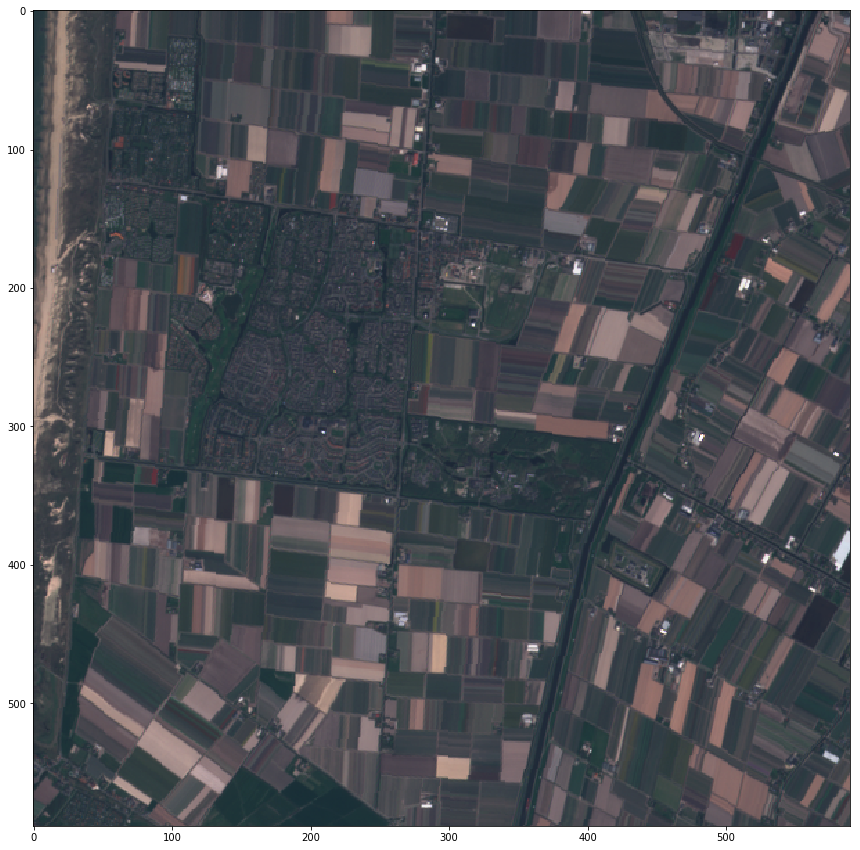

In [8]:
# If mask_maps is not None, for every image in images, each is overlayed with different color
overlay_cloud_mask(true_c[9], [cloud_masks[9]], mask_maps = [[255, 0, 0]])
#plt.savefig('./ImageRegression/fields.png')

In [141]:
from sklearn.model_selection import train_test_split

In [142]:
def split_train_test_cv(data, train_p=0.5, cv_p=0.5, shuffle=None, state=None):
    if shuffle is 0:
        print("Probably not what you want")
    train, test = train_test_split(data, train_size=train_p, shuffle=shuffle, random_state=state)
    cv, test = train_test_split(test, train_size=cv_p, shuffle=shuffle, random_state=state)
    return train, cv, test

In [143]:
#overlay_cloud_mask(bands[21][:,:,0], [mask_t], mask_maps = [[255, 0, 0]])
train, cv, test = split_train_test_cv(nonzero, shuffle=False)
print(len(train))
print(len(cv))
print(len(test))

29658
14829
14829


C:\Users\Matej\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [144]:
#plot_image(true_c[9])
#overlay_cloud_mask(true_c[9], [mask_t], mask_maps = [[255, 0, 0]])
#plot_image(bands[9][:,:,2], 2.5)


In [145]:
#plot_image(bands[9][:,:,1] + mask_t, 2.5)

In [146]:
bands[9][1,0,:]

array([0.124 , 0.0987, 0.0899, 0.0609, 0.0678, 0.0424, 0.0405, 0.0345,
       0.0319, 0.0132, 0.0033, 0.0145, 0.0103], dtype=float32)

In [147]:
(mask_t.shape, bands[9].shape)

((589, 590), (589, 590, 13))

In [148]:
# 5 to 12
dates[5]

datetime.datetime(2016, 3, 12, 10, 50, 37)

# Prepare data

In [149]:
y = np.array([]) #tulip
x = np.array([]) #bands in array

for i in mask_t:
    y = np.concatenate((y,i),axis=0)

x = bands[9][:,:].flatten().reshape(mask_t.shape[0]*mask_t.shape[1], 13)


print(y) 
print(x)
x.shape

[0. 0. 0. ... 0. 0. 0.]
[[0.124  0.0993 0.0896 ... 0.0033 0.0145 0.0103]
 [0.124  0.0982 0.0886 ... 0.0033 0.0146 0.0115]
 [0.124  0.0984 0.0885 ... 0.0033 0.0146 0.0115]
 ...
 [0.1481 0.1129 0.1054 ... 0.0027 0.2026 0.135 ]
 [0.1481 0.1141 0.1067 ... 0.0027 0.2026 0.135 ]
 [0.1527 0.1138 0.1044 ... 0.0028 0.2279 0.1664]]


(347510, 13)

# Learn

In [150]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import tree

In [151]:
X = x[:,0:13] #bands used for regression

In [152]:
X

array([[0.124 , 0.0993, 0.0896, ..., 0.0033, 0.0145, 0.0103],
       [0.124 , 0.0982, 0.0886, ..., 0.0033, 0.0146, 0.0115],
       [0.124 , 0.0984, 0.0885, ..., 0.0033, 0.0146, 0.0115],
       ...,
       [0.1481, 0.1129, 0.1054, ..., 0.0027, 0.2026, 0.135 ],
       [0.1481, 0.1141, 0.1067, ..., 0.0027, 0.2026, 0.135 ],
       [0.1527, 0.1138, 0.1044, ..., 0.0028, 0.2279, 0.1664]],
      dtype=float32)

In [153]:
regressor = linear_model.LogisticRegression(class_weight = 'balanced', C = 18, tol = 0.02);
#regressor = tree.DecisionTreeClassifier();

In [154]:
predicted = cross_val_predict(regressor, X, y, cv = 3);

In [155]:
from sklearn.metrics import recall_score, precision_score, f1_score

In [156]:
#plt.plot(x[:,0],y,'ro')

In [157]:
#plt.plot(x[:,0],y,'ro', x[:,0], predicted, 'x')

In [158]:
#m = 40000
#n = 60000
#plt.plot(range(len(x[:,0]))[m:n],(y - predicted)[m:n],'x')

In [159]:
#a =list(y-predicted)

#print(len(a))
#print(a.count(-1), a.count(0), a.count(1))

#print('not OK',a.count(-1)/len(a), a.count(1)/len(a),'\nOK',  a.count(0)/len(a))

### Learn

In [160]:
#dual default
#tol change
#C change
#fit_intercept default 
#intercept_scaling change
#class_weight = 'balanced'

# class_weight = 'balanced', C = 18, tol = 0.02

In [161]:
regressor = linear_model.LogisticRegression(class_weight = 'balanced', C = 18, tol = 0.02);
regressor.fit(X[0:len(train)],y[0:len(train)])

LogisticRegression(C=18, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.02, verbose=0, warm_start=False)

In [162]:
predict = regressor.predict(X[len(train):len(train) + 2*len(cv)])

In [163]:
recall = precision_score(y[len(train):len(train) + 2*len(cv)], predict)
precision = precision_score(y[len(train):len(train) + 2*len(cv)], predict, pos_label=0)
F1 = f1_score(y[len(train):len(train) + 2*len(cv)], predict)

(recall, precision, F1)

(0.3936219739292365, 0.9305515997341688, 0.5033861725087444)

In [164]:
#plt.plot(range(len(predict)),y[29658:29658 + 2*14829],'ro', range(len( predict)), predict, 'x')

In [165]:
# C2

F1_list=[]
s = 10  #step
r = 100 #range
for i in range(1, r, s):
    regressor = linear_model.LogisticRegression(class_weight='balanced', C=i);
    regressor.fit(X[0:len(train)],y[0:len(train)])
    predict = regressor.predict(X[len(train):len(train) + 2*len(cv)])
    F1 = f1_score(y[len(train):len(train) + 2*len(cv)], predict)
    
    F1_list.append([i,F1])
F1_list

[[1, 0.4678991114932646],
 [11, 0.4992195049431354],
 [21, 0.5022607664368839],
 [31, 0.5014749262536873],
 [41, 0.500992282249173],
 [51, 0.5002199736031676],
 [61, 0.499560632688928],
 [71, 0.4987195434257701],
 [81, 0.4984291663622416],
 [91, 0.4981738495252009]]

In [166]:
#tol 
c=100
F1_list=[]
s = 10  #step
r = 300 #range
f = 0.001 #faktor

for i in range(1, r, s):
    regressor = linear_model.LogisticRegression(tol = i*f, class_weight='balanced', C=18);
    regressor.fit(X[0:len(train)],y[0:len(train)])
    predict = regressor.predict(X[len(train):len(train) + 2*len(cv)])
    F1 = f1_score(y[len(train):len(train) + 2*len(cv)], predict)
    
    F1_list.append([i,F1])
F1_list

[[1, 0.5024111580977818],
 [11, 0.5033861725087444],
 [21, 0.5033861725087444],
 [31, 0.5033861725087444],
 [41, 0.5033861725087444],
 [51, 0.5033861725087444],
 [61, 0.5033861725087444],
 [71, 0.5033861725087444],
 [81, 0.5033861725087444],
 [91, 0.4923371647509579],
 [101, 0.4923371647509579],
 [111, 0.4923371647509579],
 [121, 0.4923371647509579],
 [131, 0.4923371647509579],
 [141, 0.4923371647509579],
 [151, 0.4923371647509579],
 [161, 0.4923371647509579],
 [171, 0.4923371647509579],
 [181, 0.4923371647509579],
 [191, 0.4923371647509579],
 [201, 0.4923371647509579],
 [211, 0.4923371647509579],
 [221, 0.4923371647509579],
 [231, 0.4923371647509579],
 [241, 0.4923371647509579],
 [251, 0.4923371647509579],
 [261, 0.4923371647509579],
 [271, 0.4923371647509579],
 [281, 0.4923371647509579],
 [291, 0.4923371647509579]]

In [167]:
#from sklearn.model_selection import GridSearchCV

In [168]:
#parameters = {'C': range(1,30), 'tol': [0.001, 0.02] }

In [169]:
#grid = GridSearchCV(regressor, parameters)

In [170]:
#grid.fit(X[0:len(train)],y[0:len(train)])

In [171]:
#predict2 = grid.predict(X[len(train):len(train) + 2*len(cv)])

In [172]:
#recall_2 = precision_score(y[len(train):len(train) + 2*len(cv)], predict2)
#precision_2 = precision_score(y[len(train):len(train) + 2*len(cv)], predict2, pos_label=0)
#F1_2 = f1_score(y[len(train):len(train) + 2*len(cv)], predict2)

#(recall, precision, F1)

In [173]:
#print(grid.best_params_)

In [174]:
#to image
predicted.shape = mask_t.shape

<Figure size 432x288 with 0 Axes>

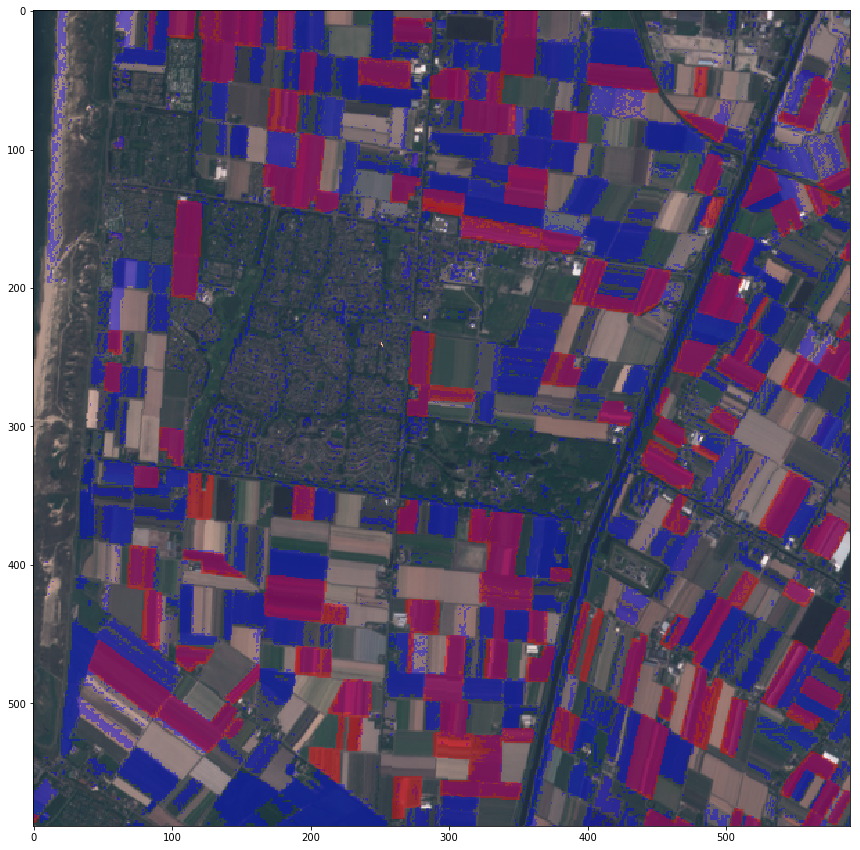

In [175]:
fig = plt.figure()
overlay_cloud_mask(true_c[11], [predicted, mask_t], mask_maps = [[0, 0, 255], [255, 0, 0]])
#plt.savefig('./ImageRegression/tulip' + '.png')
plt.show()


5 ... 2016-03-12 10:50:37
F1= 0.5141042285861437 Recall=  0.8077753051453234 Precision=  0.3770321524684849


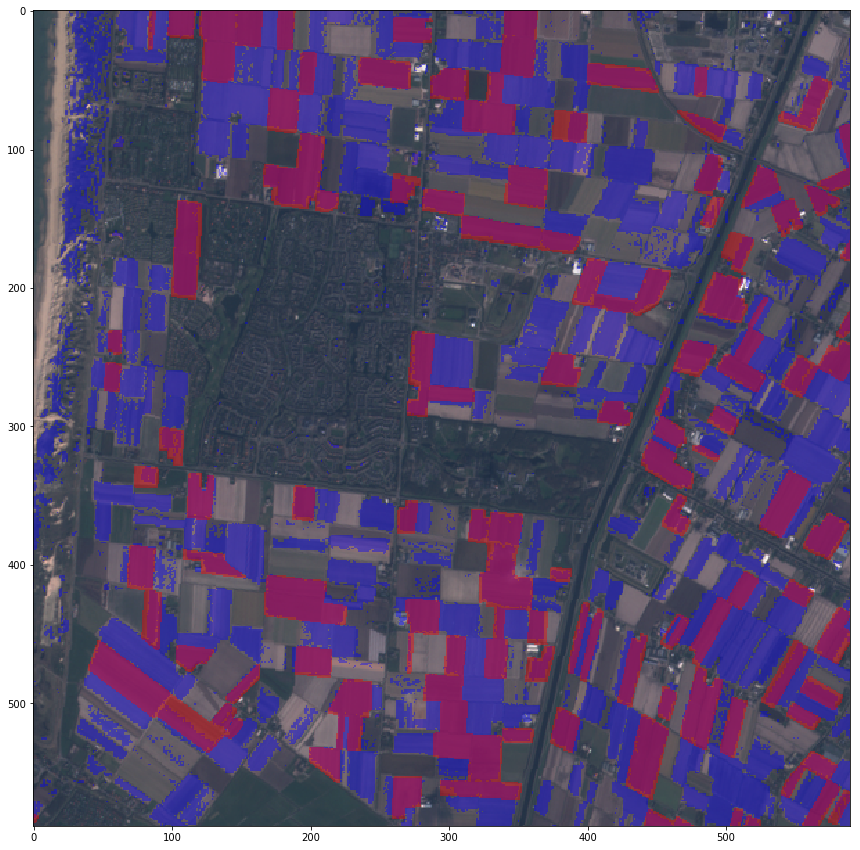

6 ... 2016-03-22 10:52:48
F1= 0.27619213090932065 Recall=  0.44219097713938904 Precision=  0.20080847056661844


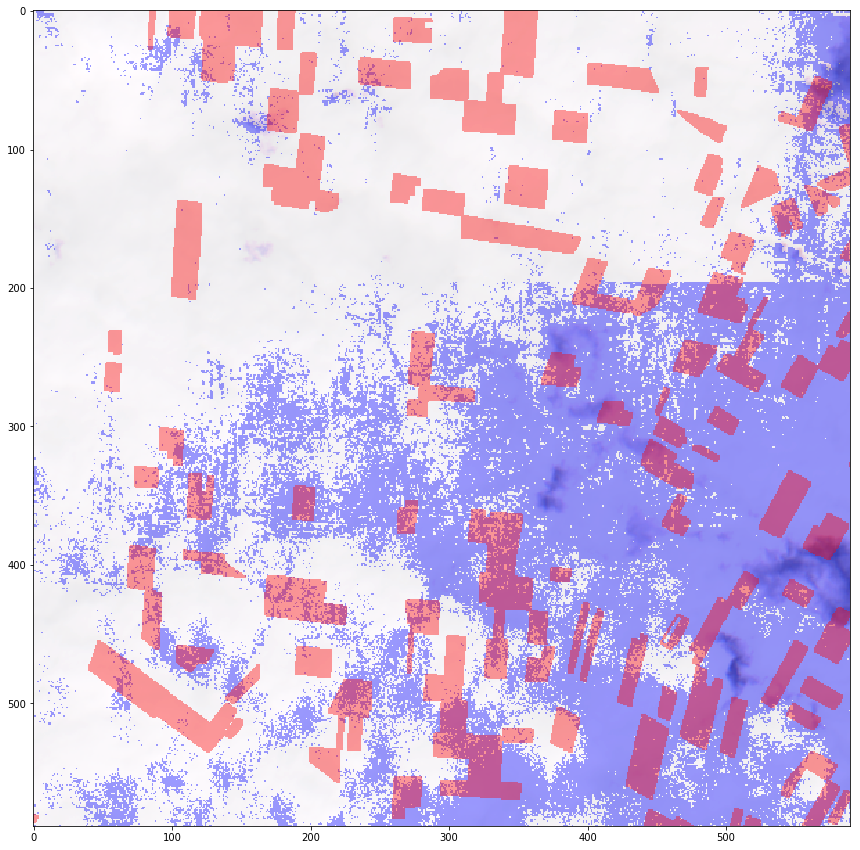

7 ... 2016-04-01 10:50:24
F1= 0.41271215230755626 Recall=  0.7475554656416481 Precision=  0.28503840838234823


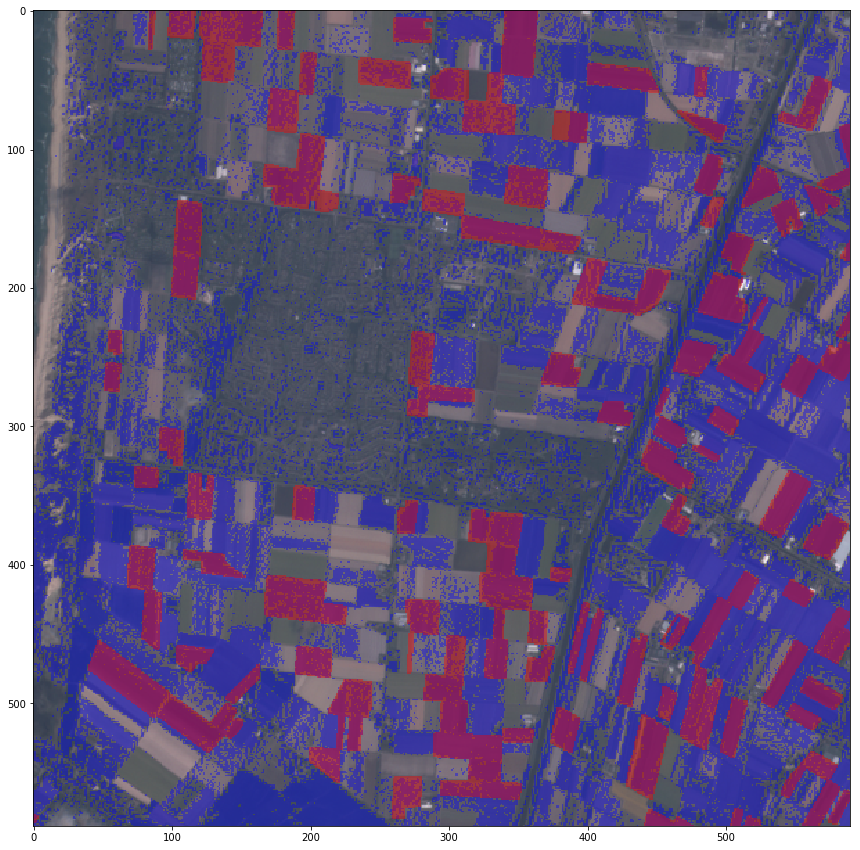

8 ... 2016-04-11 10:50:25
F1= 0.46701926709482433 Recall=  0.7294321936745566 Precision=  0.34345976153809515


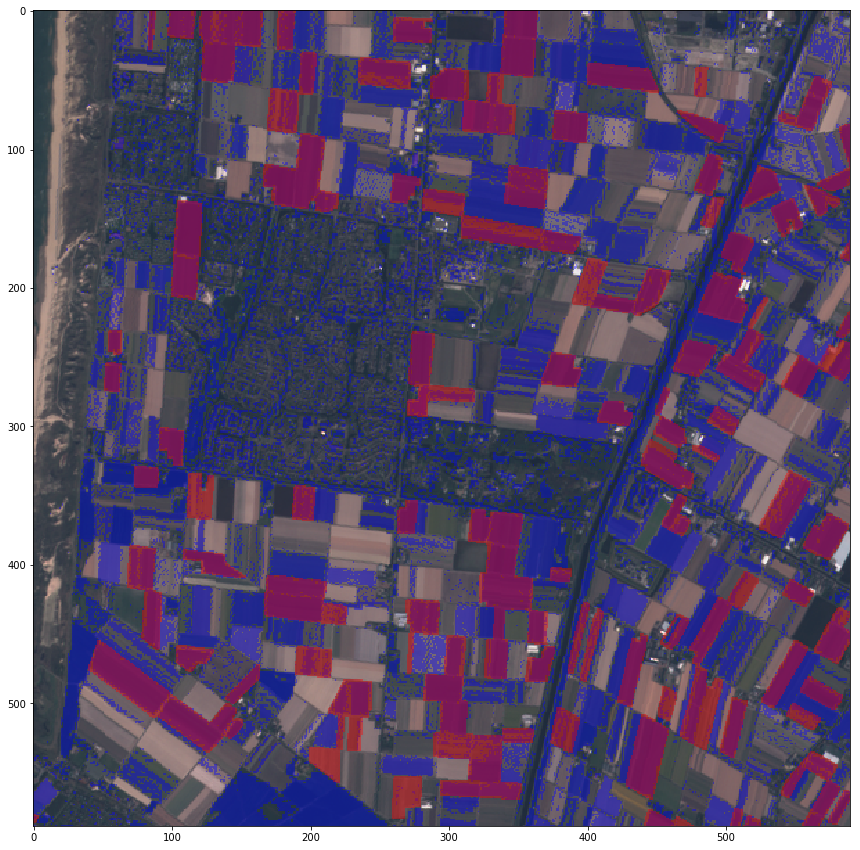

9 ... 2016-04-21 10:50:29
F1= 0.5197990781503234 Recall=  0.7623912603681975 Precision=  0.3943251774472018


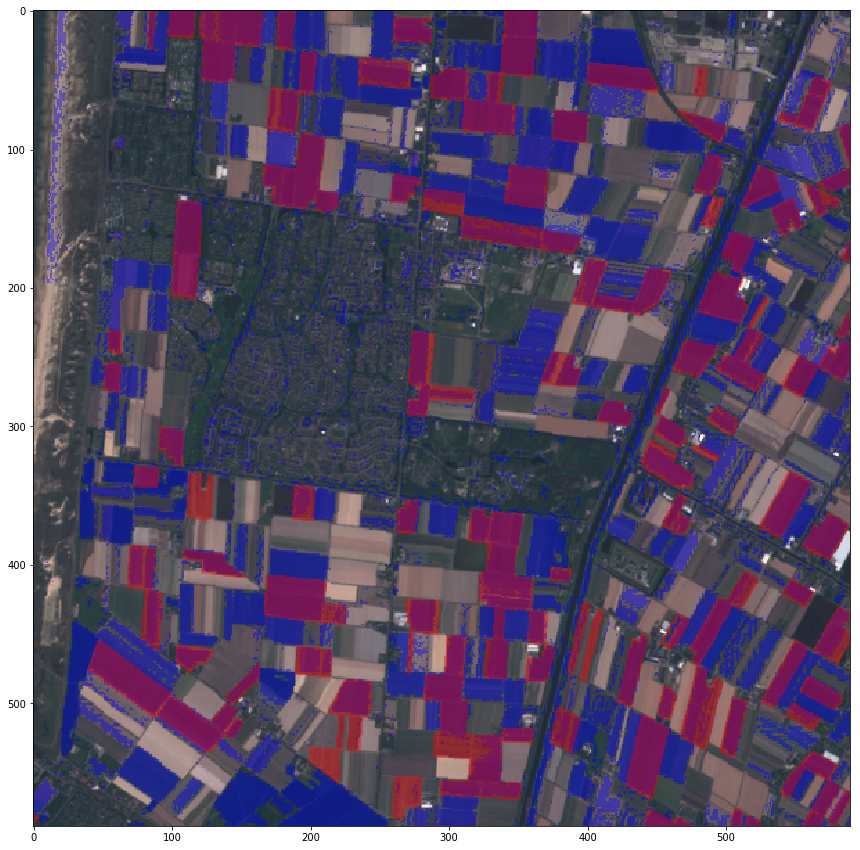

10 ... 2016-05-01 10:53:10
F1= 0.5434771982990372 Recall=  0.7498145525659181 Precision=  0.42619494806240177


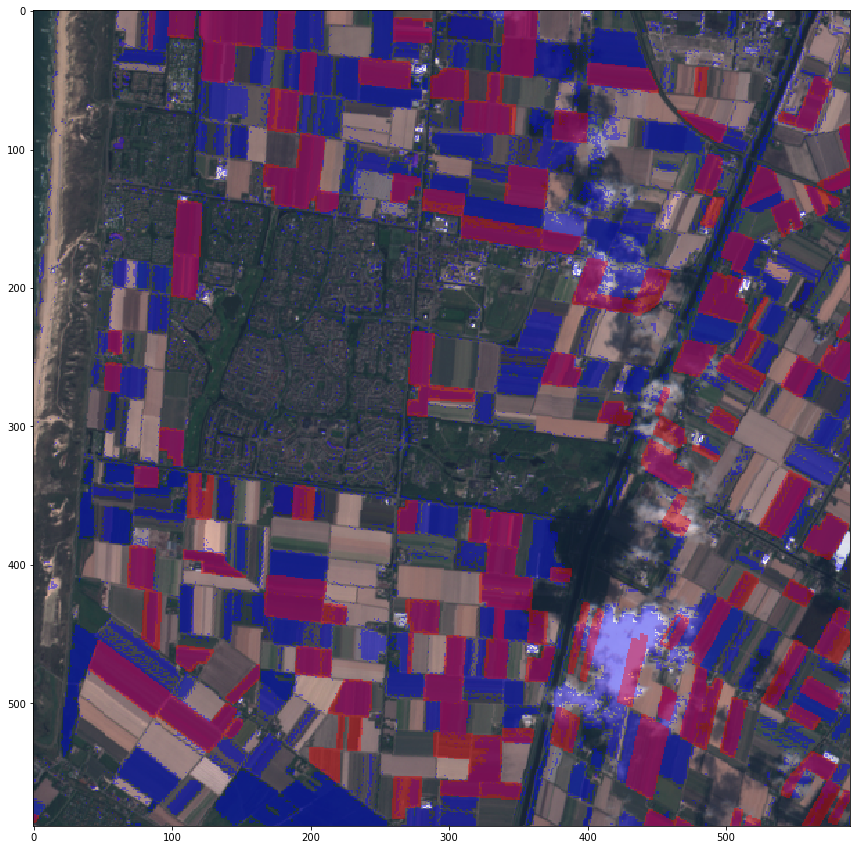

11 ... 2016-05-11 10:53:43
F1= 0.6452841104017975 Recall=  0.8086013891698699 Precision=  0.5368531805106278


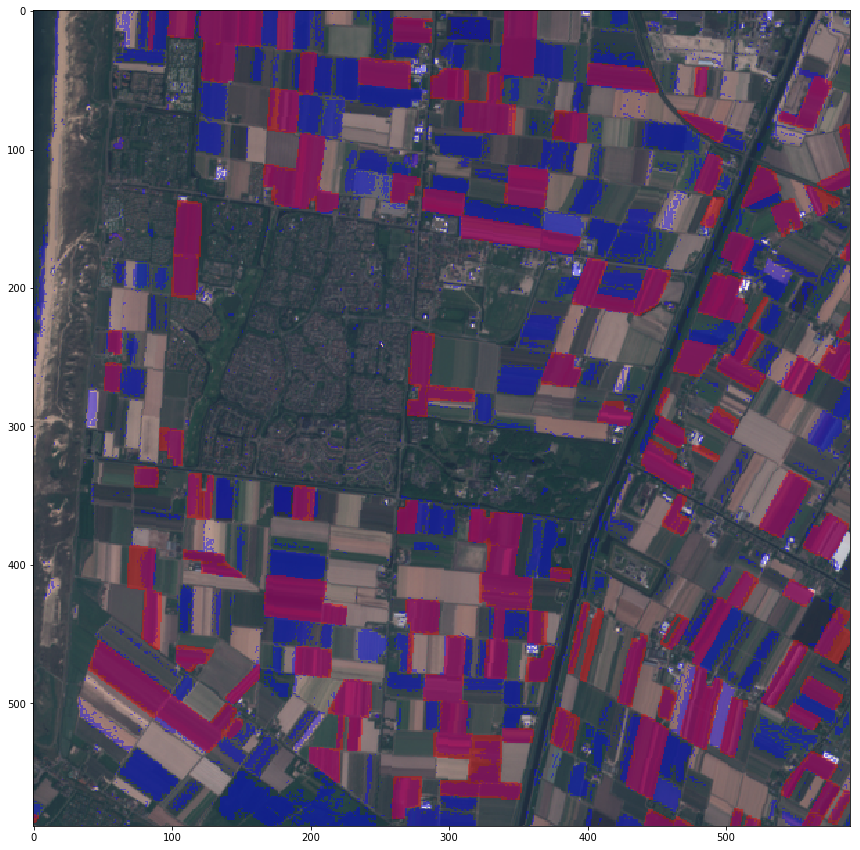

12 ... 2016-05-21 10:55:53
F1= 0.31948078327441204 Recall=  0.556848067974914 Precision=  0.22399750435720245


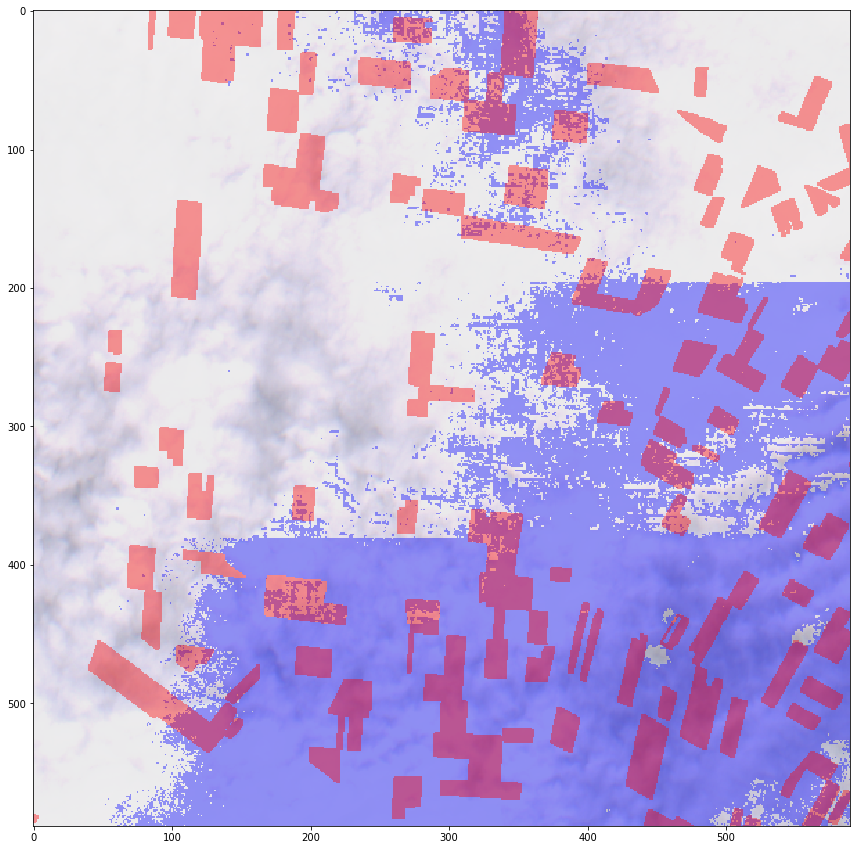

Wall time: 48.4 s


In [176]:
%%time
n=5
i=n
regressor = linear_model.LogisticRegression(class_weight = 'balanced', C = 18, tol = 0.02);

while i<13:
    x = bands[i][:,:].flatten().reshape(mask_t.shape[0]*mask_t.shape[1], 13)
    X = x[:,1:13]
    predicted2 = cross_val_predict(regressor, X, y, cv = 3);
    print(i,'...' ,dates[i])
    print('F1=', f1_score(y, predicted2), 'Recall= ', recall_score(y, predicted2),'Precision= ', precision_score(y, predicted2))
    predicted2.shape = mask_t.shape
    overlay_cloud_mask(true_c[i], [predicted2, mask_t], mask_maps = [[0, 0, 255], [255, 0, 0]])
    plt.savefig('./ImageRegression/tulip' + str(i) + '.png')
    plt.show()
    i = i+1
    